# Importações e organização dos dados

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, make_scorer, confusion_matrix


In [165]:
#variáveis úteis
meta_data_path = 'Data/sinais.csv'
data_folder = 'Data/Sinais/'

reference_kp_ids = [23, 24]
visibility_threshold = 0.1

random_state = 12



#carregando os Meta-dados
meta_data = pd.read_csv(meta_data_path)

#verificando valores nulos
meta_data.isnull().sum()



file_name       1
width           0
height          0
duration_sec    0
num_frames      0
sinal           0
interprete      0
dtype: int64

In [166]:
#removendo valores nulos
meta_data = meta_data.dropna()

"""
    - Como vou estabelecer um keypoint de referência, as dimensões do vídeo deixam de importar.
    - Com o objetivo de generalizar os modelos, o interprete também não deve ser levado em consideração.
    - Já que o frame rate é fixo em 30 fps para todos os vídeos, número de frames e duração são redundantes.
"""
#removendo colunas desnecessárias
meta_data = meta_data.drop(columns=['width', 'height', 'interprete', 'duration_sec'])

#carregando dados
data = []
for index, row in meta_data.iterrows():
    file_path = data_folder + row['file_name']
    
    # Carregando o JSON
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    
    signal_data = {
        'label': row['sinal'],
        'num_frames': row['num_frames'],
        'frames': json_data['frames']
    }
    data.append(signal_data)

data[0]

{'label': 'Adição',
 'num_frames': 136,
 'frames': [{'frame': 0,
   'keypoints': [{'id': 0, 'x': 417, 'y': 183, 'z': -1.41, 'visibility': 1.0},
    {'id': 1, 'x': 443, 'y': 153, 'z': -1.34, 'visibility': 1.0},
    {'id': 2, 'x': 455, 'y': 153, 'z': -1.34, 'visibility': 1.0},
    {'id': 3, 'x': 465, 'y': 154, 'z': -1.34, 'visibility': 1.0},
    {'id': 4, 'x': 400, 'y': 154, 'z': -1.33, 'visibility': 1.0},
    {'id': 5, 'x': 387, 'y': 155, 'z': -1.33, 'visibility': 1.0},
    {'id': 6, 'x': 374, 'y': 156, 'z': -1.33, 'visibility': 1.0},
    {'id': 7, 'x': 487, 'y': 170, 'z': -0.86, 'visibility': 1.0},
    {'id': 8, 'x': 362, 'y': 173, 'z': -0.82, 'visibility': 1.0},
    {'id': 9, 'x': 446, 'y': 220, 'z': -1.23, 'visibility': 1.0},
    {'id': 10, 'x': 393, 'y': 222, 'z': -1.22, 'visibility': 1.0},
    {'id': 11, 'x': 602, 'y': 386, 'z': -0.57, 'visibility': 1.0},
    {'id': 12, 'x': 261, 'y': 381, 'z': -0.51, 'visibility': 1.0},
    {'id': 13, 'x': 672, 'y': 639, 'z': -0.59, 'visibility': 

# Pré-processamento dos keypoints

In [167]:
#verificando se todos os frames possuem 33 keypoints                
cout = 0
for signal in data:
    for frame in signal['frames']:
        if len(frame['keypoints']) != 33:
            cout += 1
            print(len(frame['keypoints']))
print(f'quantidade de frames com menos de 33 kp: {cout}')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
quantidade de frames com menos de 33 kp: 18


In [168]:
# Removendo frames que não possuem 33 keypoints e corrigindo num_frames
for signal in data:
    frames_filtrados = [frame for frame in signal['frames'] if len(frame['keypoints']) == 33]
    signal['frames'] = frames_filtrados
    signal['num_frames'] = len(frames_filtrados)

In [169]:
"""
    Como dito antes vamos definir um ponto de referência e então calcular o X, Y e Z de todos os keypoints a partir desse ponto de referência,
    dessa forma alem de não dependermos da altura e largura da imagem, a posição de cada keypoint passa a ser relativa ao corpo do interprete,
    tornando a representação mais consistente entre vídeos.
"""
# Definindo os keypoints de referência na linha da cintura

def pre_process_keypoints(data):
    for signal in data:
        for frame in signal['frames']:
            
            # Calcula ponto de referência médio (cintura)
            ref_points = [frame['keypoints'][i] for i in reference_kp_ids]
            ref_x = np.mean([p['x'] for p in ref_points])
            ref_y = np.mean([p['y'] for p in ref_points])
            ref_z = np.mean([p['z'] for p in ref_points])
            
            
            # Ajusta todos os keypoints em relação ao ponto de referência
            for kp in frame['keypoints']:
                kp['x'] -= ref_x
                kp['y'] -= ref_y
                kp['z'] -= ref_z
                
pre_process_keypoints(data)


In [170]:
"""
    Calcula média, mínimo e máximo de visibilidade para cada keypoint
"""

def compute_visibility_stats(data, n_keypoints=33):
   
    visibility_sums = np.zeros(n_keypoints)
    counts = np.zeros(n_keypoints)
    visibility_min = np.full(n_keypoints, np.inf)
    visibility_max = np.full(n_keypoints, -np.inf)
    
    for signal in data:
        for frame in signal['frames']:
            for kp in frame['keypoints']:
                id = kp['id']
                visibility = kp['visibility']
                visibility_sums[id] += visibility
                counts[id] += 1
                visibility_min[id] = min(visibility_min[id], visibility)
                visibility_max[id] = max(visibility_max[id], visibility)

    mean_visibility = visibility_sums / counts
    return mean_visibility, visibility_min, visibility_max
    

mean_vis, min_vis, max_vis = compute_visibility_stats(data)


#Analisa se a visibilidade média de cada keypoint é maior que o limiar
kp_to_keep = [i for i, visibility in enumerate(mean_vis) if visibility >= visibility_threshold]


#exibindo resultados
for i in range(33):
    print(f'Keypoint {i}: Mean={mean_vis[i]:.3f}, Min={min_vis[i]:.3f}, Max={max_vis[i]:.3f}')
    
print(f'Keypoints a serem mantidos (visibilidade média >= {visibility_threshold}): {kp_to_keep}')

Keypoint 0: Mean=1.000, Min=0.990, Max=1.000
Keypoint 1: Mean=1.000, Min=0.990, Max=1.000
Keypoint 2: Mean=1.000, Min=0.990, Max=1.000
Keypoint 3: Mean=1.000, Min=0.990, Max=1.000
Keypoint 4: Mean=1.000, Min=0.990, Max=1.000
Keypoint 5: Mean=1.000, Min=0.990, Max=1.000
Keypoint 6: Mean=1.000, Min=0.990, Max=1.000
Keypoint 7: Mean=1.000, Min=0.990, Max=1.000
Keypoint 8: Mean=1.000, Min=0.990, Max=1.000
Keypoint 9: Mean=1.000, Min=0.990, Max=1.000
Keypoint 10: Mean=1.000, Min=0.990, Max=1.000
Keypoint 11: Mean=1.000, Min=1.000, Max=1.000
Keypoint 12: Mean=1.000, Min=0.990, Max=1.000
Keypoint 13: Mean=0.998, Min=0.890, Max=1.000
Keypoint 14: Mean=0.997, Min=0.900, Max=1.000
Keypoint 15: Mean=0.987, Min=0.210, Max=1.000
Keypoint 16: Mean=0.980, Min=0.150, Max=1.000
Keypoint 17: Mean=0.969, Min=0.120, Max=1.000
Keypoint 18: Mean=0.952, Min=0.090, Max=1.000
Keypoint 19: Mean=0.971, Min=0.150, Max=1.000
Keypoint 20: Mean=0.956, Min=0.100, Max=1.000
Keypoint 21: Mean=0.971, Min=0.150, Max=1.00

In [171]:
# Removendo keypoints com visibilidade média abaixo do limiar estabelecido
for signal in data:
    for frame in signal['frames']:
        frame['keypoints'] = [kp for kp in frame['keypoints'] if kp['id'] in kp_to_keep]
        
data[0]

{'label': 'Adição',
 'num_frames': 136,
 'frames': [{'frame': 0,
   'keypoints': [{'id': 0,
     'x': np.float64(-8.0),
     'y': np.float64(-691.0),
     'z': np.float64(-1.41),
     'visibility': 1.0},
    {'id': 1,
     'x': np.float64(18.0),
     'y': np.float64(-721.0),
     'z': np.float64(-1.34),
     'visibility': 1.0},
    {'id': 2,
     'x': np.float64(30.0),
     'y': np.float64(-721.0),
     'z': np.float64(-1.34),
     'visibility': 1.0},
    {'id': 3,
     'x': np.float64(40.0),
     'y': np.float64(-720.0),
     'z': np.float64(-1.34),
     'visibility': 1.0},
    {'id': 4,
     'x': np.float64(-25.0),
     'y': np.float64(-720.0),
     'z': np.float64(-1.33),
     'visibility': 1.0},
    {'id': 5,
     'x': np.float64(-38.0),
     'y': np.float64(-719.0),
     'z': np.float64(-1.33),
     'visibility': 1.0},
    {'id': 6,
     'x': np.float64(-51.0),
     'y': np.float64(-718.0),
     'z': np.float64(-1.33),
     'visibility': 1.0},
    {'id': 7,
     'x': np.float64(62

# Preparação dos embeddings

In [172]:
"""
    Para não perder muita informação temporal, vamos dividir os frames em segmentos e calcular a média dos keypoints em cada segmento.
    Assim, se tivermos 150 frames e 15 segmentos, cada segmento terá 10
"""

def temporal_embedding(data, n_segments=15):
    for signal in data:
        n_frames = signal['num_frames']
        segment_size = n_frames // n_segments
        embedded_frames = []
        # Divide os frames em segmentos temporais
        for i in range(n_segments):
            start = i * segment_size
            # O último segmento pega até o final
            end = (i + 1) * segment_size if i < n_segments - 1 else n_frames
            segment = signal['frames'][start:end]
            # soma dos dados de todos os frames do segmento
            frames_sum = {
                'frame': i,
                'keypoints': [{'id': kp['id'], 'x': 0, 'y': 0, 'z': 0, 'visibility': 0} for kp in segment[0]['keypoints']]
            }
            # Soma os valores dos keypoints em todos os frames do segmento
            for frame in segment:
                for i, kp in enumerate(frame['keypoints']):
                    frames_sum['keypoints'][i]['x'] += kp['x']
                    frames_sum['keypoints'][i]['y'] += kp['y']
                    frames_sum['keypoints'][i]['z'] += kp['z']
                    frames_sum['keypoints'][i]['visibility'] += kp['visibility']
            # Calcula a média dos keypoints para o segmento
            avg_frame = {
                'frame': frames_sum['frame'],
                'keypoints': [{'id': kp['id'],
                               'x': kp['x'] / len(segment),
                               'y': kp['y'] / len(segment),
                               'z': kp['z'] / len(segment),
                               'visibility': kp['visibility'] / len(segment)} for kp in frames_sum['keypoints']]
            }
            # Adiciona o frame médio à lista de embeddings
            embedded_frames.append(avg_frame)
        signal['frames'] = embedded_frames
        signal['num_frames'] = len(embedded_frames)
    

temporal_embedding(data)
data[0]

{'label': 'Adição',
 'num_frames': 15,
 'frames': [{'frame': 0,
   'keypoints': [{'id': 0,
     'x': np.float64(-8.666666666666666),
     'y': np.float64(-693.0),
     'z': np.float64(-1.275),
     'visibility': 1.0},
    {'id': 1,
     'x': np.float64(16.11111111111111),
     'y': np.float64(-723.5555555555555),
     'z': np.float64(-1.2016666666666664),
     'visibility': 1.0},
    {'id': 2,
     'x': np.float64(29.0),
     'y': np.float64(-723.1111111111111),
     'z': np.float64(-1.2016666666666664),
     'visibility': 1.0},
    {'id': 3,
     'x': np.float64(39.77777777777778),
     'y': np.float64(-722.0),
     'z': np.float64(-1.2016666666666664),
     'visibility': 1.0},
    {'id': 4,
     'x': np.float64(-26.22222222222222),
     'y': np.float64(-722.7777777777778),
     'z': np.float64(-1.2005555555555556),
     'visibility': 1.0},
    {'id': 5,
     'x': np.float64(-39.44444444444444),
     'y': np.float64(-721.8888888888889),
     'z': np.float64(-1.2005555555555556),
     

# Converção para data frame e PCA

In [173]:
#Convertendo data para um DataFrame
for signal in data:
    features = {}

    for frame in signal['frames']:
        for kp in frame['keypoints']:
            for cord in ['x', 'y', 'z', 'visibility']:
                features[f'f_{frame["frame"]}_kp_{kp["id"]}_{cord}'] = kp[cord]
    signal['features'] = features
    
df = pd.DataFrame([{'label': signal['label'], **signal['features']} for signal in data])
    


In [174]:
# ANÁLISE DO DATAFRAME

print("=" * 50)
print("INFORMAÇÕES BÁSICAS DO DATASET")
print("=" * 50)

print(f"Shape do DataFrame: {df.shape}")
print(f"Número de amostras: {df.shape[0]}")
print(f"Número de features: {df.shape[1] - 1}")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES")
print("=" * 50)

print(df['label'].value_counts())
print(f"\nNúmero de classes únicas: {df['label'].nunique()}")



INFORMAÇÕES BÁSICAS DO DATASET
Shape do DataFrame: (2501, 1621)
Número de amostras: 2501
Número de features: 1620
Memória utilizada: 31.06 MB

DISTRIBUIÇÃO DAS CLASSES
label
Adição              101
Aluno               101
Antropologia        100
Apontador           100
Apostila            100
Biologia            100
Capítulo            100
Classe              100
Coerência           100
Ensinar             100
Coesão              100
Colega              100
Conceito            100
Contexto            100
Curso               100
Dicionário          100
Disciplina          100
Física              100
Escola              100
Estudar             100
Filosofia           100
História            100
Geografia           100
Ângulo              100
Bolsa de Estudos     99
Name: count, dtype: int64

Número de classes únicas: 25


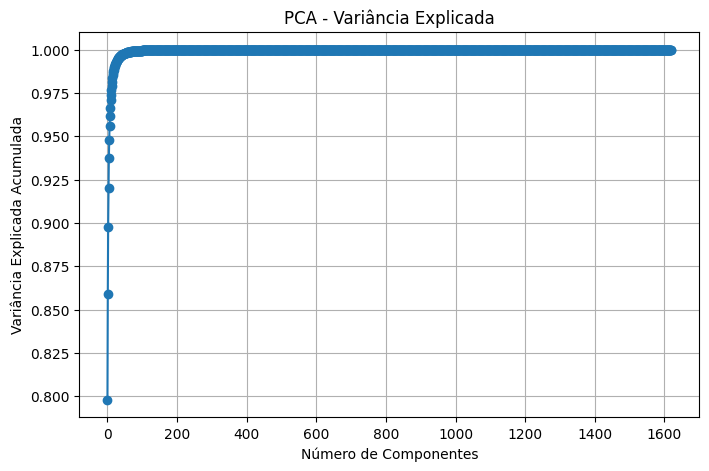

In [175]:
"""
    Tendo em vista a quantidade de features, vamos aplicar PCA para reduzir a dimensionalidade.
"""
# Separação de X e y
X = df.drop(columns=['label'])
y = df['label']


# Vamos utilizar PCA para reduzir a dimencionalidade
pca = PCA()
X_pca = pca.fit_transform(X)

# Calcula a variância explicada acumulada pelos componentes principais
explained_variance = pca.explained_variance_ratio_.cumsum()

# Plota a variância explicada acumulada em função do número de componentes
plt.figure(figsize=(8,5))
plt.plot(explained_variance, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada")
plt.grid(True)
plt.show()

In [176]:
"""
    Pode-se observar que conseguimos uma explicabilidade proxima de 100% com menos de 200 componentes. 
"""

for exp_var in np.arange(0.95, 0.991, 0.01):
    pca_tmp = PCA(n_components=exp_var, random_state=random_state)
    pca_tmp.fit(X)
    print(f'Explicabilidade: {exp_var:.2f} -> Número de componentes: {pca_tmp.n_components_}')

Explicabilidade: 0.95 -> Número de componentes: 7
Explicabilidade: 0.96 -> Número de componentes: 8
Explicabilidade: 0.97 -> Número de componentes: 10
Explicabilidade: 0.98 -> Número de componentes: 14
Explicabilidade: 0.99 -> Número de componentes: 22


In [177]:
# Com 98% conseguimos uma grande redução de dimensionalidade sem muita perda de informação

pca = PCA(n_components=0.98, random_state=random_state)

# Análise Supervisionada

In [191]:
"""
    Vamos começar a analise supervisionada, decidi realizar o tunning dos parametros para um melhor ajuste dos modelos, para evitar overfitting
    vou utiluzar NestedCV. 
"""

#Padronização dos dados
scoring = make_scorer(f1_score, average='macro', zero_division=0)

#configurações do NestedCV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

#grids de parametros para tunning
param_grid_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5], 
    'clf__min_samples_leaf': [1, 2]
}


param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

param_grid_mlp = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'clf__activation': ['relu', 'tanh'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__learning_rate_init': [0.001, 0.01]
}


#definição de pipelines
RF_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('clf', RandomForestClassifier(random_state=random_state))
])

KNN_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('clf', KNeighborsClassifier())
])

MLP_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('clf', MLPClassifier(max_iter=500, random_state=random_state))
])



In [ ]:
#Random Forest
grid_search_rf = GridSearchCV(RF_pipeline, param_grid_rf, cv=inner_cv, scoring=scoring, n_jobs=-1, error_score='raise')
nested_scores_rf = cross_val_score(grid_search_rf, X, y, cv=outer_cv, n_jobs=-1)
print(f'Random Forest - F1 Score (macro) médio: {nested_scores_rf.mean():.4f} ± {nested_scores_rf.std():.4f}')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ~~~~~~~~~^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 607, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
            ~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\parallel.py", line 147, in __call__
    return self.function(*args, **kwargs)
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 881, in _fit_and_score
    test_scores = _score(
        estimator, X_test, y_test, scorer, score_params_test, error_score
    )
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response_method, **kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_response.py", line 207, in _get_response_values
    raise ValueError(
    ...<2 lines>...
    )
ValueError: pos_label=1 is not a valid label: It should be one of ['Adição' 'Aluno' 'Antropologia' 'Apontador' 'Apostila' 'Biologia'
 'Bolsa de Estudos' 'Capítulo' 'Classe' 'Coerência' 'Coesão' 'Colega'
 'Conceito' 'Contexto' 'Curso' 'Dicionário' 'Disciplina' 'Ensinar'
 'Escola' 'Estudar' 'Filosofia' 'Física' 'Geografia' 'História' 'Ângulo']
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1051, in fit
    self._run_search(evaluate_candidates)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1605, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 997, in evaluate_candidates
    out = parallel(
        delayed(_fit_and_score)(
    ...<13 lines>...
        )
    )
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\parallel.py", line 82, in __call__
    return super().__call__(iterable_with_config_and_warning_filters)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 2072, in __call__
    return output if self.return_generator else list(output)
                                                ~~~~^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 1682, in _get_outputs
    yield from self._retrieve()
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 1784, in _retrieve
    self._raise_error_fast()
    ~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 1859, in _raise_error_fast
    error_job.get_result(self.timeout)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 758, in get_result
    return self._return_or_raise()
           ~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\yanfc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 773, in _return_or_raise
    raise self._result
ValueError: pos_label=1 is not a valid label: It should be one of ['Adição' 'Aluno' 'Antropologia' 'Apontador' 'Apostila' 'Biologia'
 'Bolsa de Estudos' 'Capítulo' 'Classe' 'Coerência' 'Coesão' 'Colega'
 'Conceito' 'Contexto' 'Curso' 'Dicionário' 'Disciplina' 'Ensinar'
 'Escola' 'Estudar' 'Filosofia' 'Física' 'Geografia' 'História' 'Ângulo']


# Análise não supervisionada

In [182]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
RF_pipeline.fit(X_train, y_train)
y_pred = RF_pipeline.predict(X_test)
print(f'F1 macro: {f1_score(y_test, y_pred, average="macro")}')

F1 macro: 0.8764531652393849
